In [1]:
from functions import *

In [2]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
import shutil
from matplotlib.colors import LogNorm

# Load data

#### Load raw data paths

In [5]:
W = 256
source_path = '../data/raw/'
data_paths = ['lst','ndvi']#, 'ndvi', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {}
for i,dir_p in enumerate(dir_paths):
    all_dir_paths[data_paths[i]] = []
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p:
            if not files and not dirs:
                os.rmdir(subdir)
            else:
                all_dir_paths[data_paths[i]].append(subdir)
        #data, times = load_data(dir_paths,W,list_rgb)
all_dir_paths


{'lst': ['../data/raw/lst/cell_67',
  '../data/raw/lst/cell_70',
  '../data/raw/lst/cell_31',
  '../data/raw/lst/cell_19',
  '../data/raw/lst/cell_71',
  '../data/raw/lst/cell_49',
  '../data/raw/lst/cell_13',
  '../data/raw/lst/cell_41',
  '../data/raw/lst/cell_21',
  '../data/raw/lst/cell_11',
  '../data/raw/lst/cell_58',
  '../data/raw/lst/cell_56',
  '../data/raw/lst/cell_62',
  '../data/raw/lst/cell_72',
  '../data/raw/lst/cell_65',
  '../data/raw/lst/cell_9',
  '../data/raw/lst/cell_69',
  '../data/raw/lst/cell_46',
  '../data/raw/lst/cell_54',
  '../data/raw/lst/cell_20',
  '../data/raw/lst/cell_22',
  '../data/raw/lst/cell_38',
  '../data/raw/lst/cell_7',
  '../data/raw/lst/cell_75',
  '../data/raw/lst/cell_12',
  '../data/raw/lst/cell_48',
  '../data/raw/lst/cell_14',
  '../data/raw/lst/cell_73',
  '../data/raw/lst/cell_51',
  '../data/raw/lst/cell_81',
  '../data/raw/lst/cell_45',
  '../data/raw/lst/cell_1',
  '../data/raw/lst/cell_79',
  '../data/raw/lst/cell_15',
  '../data

In [3]:
dir_path = '../data/raw/wt'
water_temp = pd.read_csv(f'{dir_path}/water_temp.csv', index_col=0)
water_temp

1      2     3      4      5      6      7      8  \
Zeitstempel                                                                  
2013-03-01 00:00:00   5.76   1.05  2.72   2.91   3.61   5.86   3.23   7.46   
2013-04-01 00:00:00   8.16   3.23  3.62   5.43   5.91   8.54   5.20   8.94   
2013-05-01 00:00:00  12.06   5.38  4.49   6.83   8.68  12.21   8.49   9.46   
2013-06-01 00:00:00  15.15   9.05  5.01   8.56  12.00  15.21  12.85  10.42   
2013-07-01 00:00:00  19.52  12.63  6.34  10.80  15.42  21.28  17.35  11.98   
...                    ...    ...   ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  13.94   6.03  4.81   7.26  10.67  13.85  11.10  10.58   
2024-06-01 00:00:00  16.58   9.45  5.38   8.63  13.05  17.00  13.57  11.62   
2024-07-01 00:00:00  19.75  12.10  6.82  10.47  15.52  20.68  16.94  12.39   
2024-08-01 00:00:00  21.82  14.09  7.55  12.48  16.50  23.24  18.44  13.35   
2024-09-01 00:00:00  18.45  10.32  5.91   9.56  12.78  19.08  13.64  11.79   

                         9     10  ...     72     73     74     75     76  \
Zeitstempel                        ...                                      
2013-03-01 00:00:00   6.24   5.59  ...   5.96   8.20   4.04   6.69   6.04   
2013-04-01 00:00:00   8.94   8.33  ...   8.02   9.92   5.92   9.93   8.77   
2013-05-01 00:00:00  10.16  11.65  ...   8.53  10.93   6.86  13.71  10.15   
2013-06-01 00:00:00  13.67  15.12  ...  10.90  12.93   8.49  17.17  14.04   
2013-07-01 00:00:00  19.61  20.50  ...  13.75  16.97  10.80  20.67  20.99   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  12.20  13.40  ...  10.36  12.10   7.63  15.62  12.29   
2024-06-01 00:00:00  15.24  16.79  ...  12.24  13.55   9.03  18.39  15.95   
2024-07-01 00:00:00  18.90  20.38  ...  14.30  15.95  10.74  20.82  19.92   
2024-08-01 00:00:00  22.41  22.75  ...  16.34  17.93  11.85  21.27  23.87   
2024-09-01 00:00:00  16.21  18.08  ...  12.46  14.41   9.55  17.76  16.90   

                        77     78     79     80      81  
Zeitstempel                                              
2013-03-01 00:00:00   6.06   5.48   3.83   4.64    0.96  
2013-04-01 00:00:00   8.77   8.22   8.19   8.90    1.56  
2013-05-01 00:00:00  12.35  10.14  10.75  11.26    1.31  
2013-06-01 00:00:00  15.36  13.41  13.63  15.18    1.31  
2013-07-01 00:00:00  21.30  17.45  17.22  20.13    1.25  
...                    ...    ...    ...    ...     ...  
2024-05-01 00:00:00  13.95  11.97  12.41  14.02    1.79  
2024-06-01 00:00:00  17.04  14.46  14.65  16.51    1.56  
2024-07-01 00:00:00  20.67  17.49  17.22  19.97   Lücke  
2024-08-01 00:00:00  23.25  18.12  18.68  21.36  223.36  
2024-09-01 00:00:00  19.28  14.64  15.01  15.49    0.19  

[139 rows x 81 columns]

In [47]:
water_temp.index

Index(['2013-03', '2013-04', '2013-05', '2013-06', '2013-07', '2013-08',
       '2013-09', '2013-10', '2013-11', '2013-12',
       ...
       '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05',
       '2024-06', '2024-07', '2024-08', '2024-09'],
      dtype='object', name='Zeitstempel', length=139)

In [46]:
water_temp.index = pd.to_datetime(water_temp.index).strftime('%Y-%m')


#### Old step to change ndvi images names

In [4]:
'''pattern = r'^cell_\d+_'
for path in all_dir_paths['ndvi']:
    image_files = os.listdir(path)
    new_files = [re.sub(pattern, '', filename) for filename in image_files]
    new_files = [new_name.replace('_','-',1) for new_name in new_files]
    for i,img in enumerate(image_files):
        old_path = os.path.join(path, img)
        new_path = os.path.join(path, new_files[i])
        print('From ', old_path,'to ', new_path)
        os.rename(old_path, new_path)'''



<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_1918851/2340356355.py:1: SyntaxWarning: invalid escape sequence '\d'
  '''pattern = r'^cell_\d+_'


"pattern = r'^cell_\\d+_'\nfor path in all_dir_paths['ndvi']:\n    image_files = os.listdir(path)\n    new_files = [re.sub(pattern, '', filename) for filename in image_files]\n    new_files = [new_name.replace('_','-',1) for new_name in new_files]\n    for i,img in enumerate(image_files):\n        old_path = os.path.join(path, img)\n        new_path = os.path.join(path, new_files[i])\n        print('From ', old_path,'to ', new_path)\n        os.rename(old_path, new_path)"

#### Obtain and  filter common cells between all variables paths

In [5]:
cell_sets = []
for key, paths in all_dir_paths.items():
    cell_ids = set()
    for path in paths:
        if os.listdir(path):
            cell_id = path.split('_')[-1]
            cell_ids.add(cell_id)
            
    #cell_ids = {path.split('_')[-1] for path in paths}  # Extrae solo el número después de "cell_"
    cell_sets.append(cell_ids)

# Obtener la intersección de todos los sets de cell_ids
common_cells = set.intersection(*cell_sets)

# Filtrar cada lista en el diccionario según los cell_ids comunes
filtered_data = {}
for key, paths in all_dir_paths.items():
    filtered_data[key] = [path for path in paths if path.split('_')[-1] in common_cells]

for k,v in filtered_data.items():
    print(k,len(v))
    for el in v:
        print(len(os.listdir(el)))
    print()

lst 24
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82

wt 24
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82

ndvi 24
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82
82



In [6]:
### Check
for k,v in filtered_data.items():
    print(k,len(v))
    for i,el in enumerate(v):
        p1=filtered_data['wt'][i].split('_')[-1]
        p2=filtered_data['lst'][i].split('_')[-1]
        p3=filtered_data['ndvi'][i].split('_')[-1]
        print(p1,p2,p3)
        
    print()

lst 24
163 163 163
201 201 201
146 146 146
398 398 398
72 72 72
180 180 180
212 212 212
106 106 106
23 23 23
222 222 222
379 379 379
176 176 176
386 386 386
296 296 296
321 321 321
197 197 197
237 237 237
93 93 93
367 367 367
279 279 279
354 354 354
239 239 239
27 27 27
4 4 4

wt 24
163 163 163
201 201 201
146 146 146
398 398 398
72 72 72
180 180 180
212 212 212
106 106 106
23 23 23
222 222 222
379 379 379
176 176 176
386 386 386
296 296 296
321 321 321
197 197 197
237 237 237
93 93 93
367 367 367
279 279 279
354 354 354
239 239 239
27 27 27
4 4 4

ndvi 24
163 163 163
201 201 201
146 146 146
398 398 398
72 72 72
180 180 180
212 212 212
106 106 106
23 23 23
222 222 222
379 379 379
176 176 176
386 386 386
296 296 296
321 321 321
197 197 197
237 237 237
93 93 93
367 367 367
279 279 279
354 354 354
239 239 239
27 27 27
4 4 4



#### Delete data from 2011-01 to 2013-02 (data collection error)

In [7]:
from datetime import datetime
start_date = datetime.strptime("2011-01", "%Y-%m")
end_date = datetime.strptime("2013-02", "%Y-%m")
        
for k, v in filtered_data.items():
    if k != 'ndvi':
        for el in v:
            files = os.listdir(el)
            
            # Iterar sobre los archivos en el directorio
            for filename in files:
                # Extraer la fecha (YYYY-MM) del nombre del archivo
                try:
                    date_str = filename.split('_')[-1].split('.')[0]  # Asumiendo que la fecha está al inicio del nombre
                    file_date = datetime.strptime(date_str, "%Y-%m")
                    
                    # Verificar si la fecha está dentro del rango y eliminar el archivo si corresponde
                    if start_date <= file_date <= end_date:
                        file_path = os.path.join(el, filename)
                        os.remove(file_path)
                        print(f"Eliminado: {file_path}")
                except ValueError:
                    # Ignorar archivos que no tengan el formato de fecha esperado
                    print(f"Formato de fecha no válido en: {filename}")

#### Load images and times

In [7]:
t=[]
total_data = {}
for k,v in all_dir_paths.items():
    print('doing',k)
    if k == 'lst':
        list_rgb = [True]*len(v)
    else:
        list_rgb = [False]*len(v)
    data, times = load_data(v,W,list_rgb)
    filtered = [arr for arr in data.values() if arr.size > 0]
    total_data[k] = np.concatenate(filtered, axis=0)
    print(total_data[k].shape)
    t.append(times)

doing lst
(6672, 256, 256, 3)
doing ndvi


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


(6672, 256, 256)


In [21]:
total_cells = []
for v in all_dir_paths['lst']:
    cell = v.split('/')[-1]
    total_cells.extend([cell]*len(times[0]))
    

In [28]:
lst = total_data['lst']
ndvi = total_data['ndvi']
#data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
#print('targets shape:', data_targets.shape)

inputs shape: (6672, 256, 256, 3) (6672, 256, 256)


In [32]:
time_slots = [el for t in times for el in t]
time_slots = np.array(time_slots)
time_slots

array(['2013-03', '2013-04', '2013-05', ..., '2024-07', '2024-08',
       '2024-09'], dtype='<U7')

In [33]:
len(time_slots)

6672

#### Load river rasters masks

In [13]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_expanded = {}
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    if cl_int in common_cells:
        raster_path = os.path.join(dir_path, raster)
        rast,meta = load_raster(raster_path,False)
        river_masks[cc]=rast
        river_mask_expanded = np.expand_dims(rast, axis=-1)  # Expande para tener forma (height, width, 1)
        river_mask_expanded = np.repeat(river_mask_expanded, lst.shape[-1], axis=-1)  # Expande a (height, width, 3)
        river_masks_expanded[cc] = river_mask_expanded
    

#### Load rivers

In [71]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass
        

Processing file: station_cell_37.shp
Added cell_37
Processing file: station_cell_8.shp
Added cell_8
Processing file: station_cell_33.shp
Added cell_33
Processing file: station_cell_9.shp
Added cell_9
Processing file: station_cell_42.shp
Added cell_42
Processing file: station_cell_78.shp
Added cell_78
Processing file: station_cell_6.shp
Added cell_6
Processing file: station_cell_46.shp
Added cell_46
Processing file: station_cell_31.shp
Added cell_31
Processing file: station_cell_59.shp
Added cell_59
Processing file: station_cell_63.shp
Added cell_63
Processing file: station_cell_11.shp
Added cell_11
Processing file: station_cell_36.shp
Added cell_36
Processing file: station_cell_65.shp
Added cell_65
Processing file: station_cell_56.shp
Added cell_56
Processing file: station_cell_12.shp
Added cell_12
Processing file: station_cell_72.shp
Added cell_72
Processing file: station_cell_24.shp
Added cell_24
Processing file: station_cell_38.shp
Added cell_38
Processing file: station_cell_80.shp


#### Clean rivers

In [16]:
valid_directory = '../data/external/shp/cleaned_cells'
os.makedirs(valid_directory, exist_ok=True)
for k,riv in included_files.items():
    base_name = os.path.splitext(riv)[0]
    for ext in [".shp", ".shx", ".dbf", ".prj"]:
        source_path = os.path.join(output_directory, base_name + ext)
        destination_path = os.path.join(valid_directory, k + ext)
        try:
            shutil.copy(source_path, destination_path)
            print(f"Moved file: {source_path} to {destination_path}")
        except FileNotFoundError:
            pass

Moved file: ../data/external/shp/clipped_rivers_grid_cells_ogr/rivers_grid_cell_320.shp to ../data/external/shp/cleaned_cells/cell_10.shp
Moved file: ../data/external/shp/clipped_rivers_grid_cells_ogr/rivers_grid_cell_320.shx to ../data/external/shp/cleaned_cells/cell_10.shx
Moved file: ../data/external/shp/clipped_rivers_grid_cells_ogr/rivers_grid_cell_320.dbf to ../data/external/shp/cleaned_cells/cell_10.dbf
Moved file: ../data/external/shp/clipped_rivers_grid_cells_ogr/rivers_grid_cell_320.prj to ../data/external/shp/cleaned_cells/cell_10.prj
Moved file: ../data/external/shp/clipped_rivers_grid_cells_ogr/rivers_grid_cell_567.shp to ../data/external/shp/cleaned_cells/cell_21.shp
Moved file: ../data/external/shp/clipped_rivers_grid_cells_ogr/rivers_grid_cell_567.shx to ../data/external/shp/cleaned_cells/cell_21.shx
Moved file: ../data/external/shp/clipped_rivers_grid_cells_ogr/rivers_grid_cell_567.dbf to ../data/external/shp/cleaned_cells/cell_21.dbf
Moved file: ../data/external/shp/c

In [17]:
for ri in rivers.values():
    print(ri.total_bounds)

[ 7.63865346 46.3581148   7.76911984 46.4483261 ]
[ 8.95533183 46.97682189  9.08945155 47.06808034]
[ 8.55206666 46.53171755  8.68413104 46.62278574]
[ 7.64133251 47.07776938  7.77345886 47.16789253]
[ 9.10382109 47.51438559  9.23872817 47.60586249]
[ 7.50966406 47.07801618  7.64158774 47.16811255]
[ 6.46078246 46.8048195   6.59193342 46.89506311]
[ 6.98935959 46.26793024  7.11943585 46.35808893]
[ 7.77527275 47.43704925  7.90854689 47.52740124]
[ 8.16085934 46.53553596  8.29246074 46.62609235]
[ 7.50955365 46.98810963  7.64131441 47.07817063]
[ 8.44233108 47.61295793  8.57616415 47.7033752 ]
[ 8.29397559 46.71413239  8.42629668 46.80495981]
[ 8.15835255 46.35564439  8.28956477 46.44614781]
[ 8.29111638 46.53423146  8.4223643  46.62516824]
[ 7.24921546 46.1785013   7.37897171 46.26858676]
[ 8.42017068 46.44312302  8.55160655 46.53422265]
[ 7.37901531 46.08867239  7.50849487 46.17864621]
[ 8.67389934 46.17080733  8.80559477 46.26178158]
[ 6.98241016 47.07736698  7.11462758 47.16765095]


# Delete unuseful data

In [128]:
del_indices = set()
fixed_ndvi = []
test_index = 0
for index in range(0,lst.shape[0]):
  # Obtain percentage of black and white pixels of lst
  print('imatge', index)
  for k in total_data.keys():
    if k != 'wt':
        print('fent', k)
        if len(total_data[k][index].shape) == 2:
          img_gray = total_data[k][index]
        else:
          img_gray = np.dot(total_data[k][index][...,:3], [0.2989, 0.5870, 0.1140])
        
        blacks = img_gray==0
        percentage_b = np.sum(blacks)/blacks.size * 100
        whites = img_gray>=240
        percentage_w = np.sum(whites)/whites.size * 100
        num_nans = np.sum(np.isnan(img_gray))
        percentage_nans = (num_nans*100)/(img_gray.size)
        print('tinc ',num_nans,' sobre ',img_gray.size,' ocupen un percentatge', percentage_nans)
        conditions = [np.all(img_gray == img_gray[0, 0]), percentage_b > 50, percentage_w > 50,np.all(np.isnan(img_gray)), percentage_nans > 50]
        
        if True in conditions:
            del_indices.add(index)
            break
        elif k == 'ndvi':
            new_ndvi = np.where(np.isnan(total_data[k][index]), 0.0, total_data[k][index])
            fixed_ndvi.append(new_ndvi)
  print()
  

imatge 0
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  65536  sobre  65536  ocupen un percentatge 100.0

imatge 1
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  65536  sobre  65536  ocupen un percentatge 100.0

imatge 2
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0

imatge 3
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  65536  sobre  65536  ocupen un percentatge 100.0

imatge 4
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  65536  sobre  65536  ocupen un percentatge 100.0

imatge 5
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  0  sobre  65536  ocupen un percentatge 0.0

imatge 6
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0

imatge 7
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0
fent ndvi
tinc  65536  sobre  65536  ocupen un percentatge 100.0

imatge 8
fent lst
tinc  0  sobre  65536  ocupen un percentatge 0.0

imat

In [129]:
fixed_ndvi = np.array(fixed_ndvi)

In [34]:
slots = np.delete(time_slots,list(del_indices))

In [35]:
len(slots)

964

In [36]:
clean_cells = np.delete(np.array(total_cells),list(del_indices))
len(clean_cells)

964

In [130]:
len(fixed_ndvi)

964

In [131]:
wt_values = pd.DataFrame(columns=["Cell", "Date", "WaterTemp"])

for count in range(len(clean_cells)):
    keep_cell = clean_cells[count]
    keep_date = slots[count]
    temp_value=water_temp.loc[keep_date][keep_cell.split('_')[-1]]
    
    if temp_value != 'Lücke':
        new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "WaterTemp": [temp_value]})
        wt_values = pd.concat([wt_values, new_row], ignore_index=True)
    else:
        print('hola',temp_value)



/tmp/ipykernel_3731394/427511683.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wt_values = pd.concat([wt_values, new_row], ignore_index=True)


# Download preprocessed data

#### Clean preprocessed directories

In [132]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['lst', 'ndvi', 'wt']#,'wt_interpolated', 'lst/masked']
for d in data:
    dest_dir = os.path.join(preprocessed_data_path, d)
    os.makedirs(dest_dir, exist_ok=True)
    clear_directory(dest_dir)


In [133]:
os.makedirs('../data/preprocessed/wt',exist_ok=True)
wt_values.to_csv('../data/preprocessed/wt/water_temp.csv')

#### Copy preprocessed images

In [134]:
import rasterio
from rasterio.transform import from_origin, from_bounds
import numpy as np

def save_raster(raster_array, filepath, shp, resolution=30, nodata_value=0.0):
    
    resolution = 30
    x_min, y_min, x_max, y_max = shp.total_bounds
    width, height = raster_array.shape[1], raster_array.shape[0]
    resolution_x = (x_max - x_min) / width
    resolution_y = (y_max - y_min) / height

    print(width,height,raster_array.shape[0],raster_array.shape[1])
    
    #transform = from_origin(x_min, y_max, resolution, resolution)
    transform = from_bounds(x_min, y_min, x_max, y_max, width, height)

    with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=raster_array.shape[0],
        width=raster_array.shape[1],
        count=len(raster_array.shape),
        dtype=raster_array.dtype,
        crs=shp.crs.to_string(),  # Ensure correct CRS
        transform=transform,
        nodata=0.0
    ) as dst:
        if len(raster_array.shape) == 3:
            dst.write(raster_array[:, :, 0], 1)  # Red channel
            dst.write(raster_array[:, :, 1], 2)  # Green channel
            dst.write(raster_array[:, :, 2], 3)  # Blue channel
        else:
            dst.write(raster_array, 1)
    print(f"Raster saved to {filepath} with bounds {x_min}, {y_min}, {x_max}, {y_max}, {shp.crs.to_string()}")




In [135]:
from collections import Counter

for d, paths in all_dir_paths.items():
    count = 0
    included = 0
    imgs_per_river = Counter()
    imgs_out=0
    
    for cell_path in paths:
        try:
            source_dir = cell_path
            cell = cell_path.split('/')[-1]
            
            river = river_cells[cell]
            files = os.listdir(source_dir)
            sorted_files = sorted(files, key=extract_year_month_from_filename)

            dest_dir = os.path.join(preprocessed_data_path, f'{d}/{cell}')
            os.makedirs(dest_dir, exist_ok=True)
    
            for file in sorted_files:
                if count not in del_indices:
                    # Construct full file paths
                    if d == 'ndvi':
                        date = file.split('_')[-1]#.split('.')[0]
                        name = f'{dest_dir}/ndvi_{date}'
                        save_raster(fixed_ndvi[included], name, river)
                        print()
                        print('Image', included)
                        print('Obro')
                        with rasterio.open(name) as src:
                            print(f"CRS: {src.crs}")
                            print(f"Bounding Box: {src.bounds}")
                            print()
                        print(f'Copied: ndvi_{date}, at {dest_dir}')
                        print()
                        '''
                        masked_dir = f'{dest_dir}/masked'
                        os.makedirs(masked_dir, exist_ok=True)
                        name = f'{masked_dir}/ndvi_masked_{date}.tiff'
                        masked_input = fixed_ndvi[included] * river_masks[cell]
                        save_raster(masked_input, name, river)
                    
                        print(f'Copied: ndvi_masked_{date}')'''
                    
                    else:
                        #dst_path = os.path.join(dest_dir, image_file)
                        dst_path = os.path.join(dest_dir, file)
                        src_path = os.path.join(source_dir, file)
                        # Copy the file to the destination folder
                        shutil.copy(src_path, dst_path)
                        print()
                        print('Image', included)
                        print('Obro')
                        with rasterio.open(dst_path) as src:
                            print(f"CRS: {src.crs}")
                            print(f"Bounding Box: {src.bounds}")
                            print()
                        print(f'Copied: {file}, from {src_path}, to {dst_path}')
                        '''
                        if d == 'lst':
                            date = file.split('_')[1].split('.')[0]
                            masked_dir = f'{dest_dir}/masked'
                            os.makedirs(masked_dir, exist_ok=True)
                            name = f'{masked_dir}/lst_masked_{date}.tiff'
                            masked_input = lst[count] * river_masks_expanded[cell]
                            save_raster(masked_input, name, river)
                            print(f'Copied: lst_masked_{date}')'''
                    included+=1
                    imgs_per_river[cell] += 1
                count+=1
        except Exception as e:
            print(e)
            imgs_out += len(os.listdir(source_dir))
            rr = all_rivers[cell]
            print(cell)
            print()
            print('afegeixo',len(os.listdir(source_dir)), 'imatges no processades')
            count += len(os.listdir(source_dir))
            pass
        
                


Image 0
Obro
CRS: EPSG:4326
Bounding Box: BoundingBox(left=7.543069023582529, bottom=47.55237136573581, right=7.666961838136454, top=47.59643338901144)

Copied: image_2013-08.tiff, from ../data/raw/lst/cell_67/image_2013-08.tiff, to ../data/preprocessed/lst/cell_67/image_2013-08.tiff

Image 1
Obro
CRS: EPSG:4326
Bounding Box: BoundingBox(left=7.543069023582529, bottom=47.55237136573581, right=7.666961838136454, top=47.59643338901144)

Copied: image_2013-12.tiff, from ../data/raw/lst/cell_67/image_2013-12.tiff, to ../data/preprocessed/lst/cell_67/image_2013-12.tiff

Image 2
Obro
CRS: EPSG:4326
Bounding Box: BoundingBox(left=7.543069023582529, bottom=47.55237136573581, right=7.666961838136454, top=47.59643338901144)

Copied: image_2014-10.tiff, from ../data/raw/lst/cell_67/image_2014-10.tiff, to ../data/preprocessed/lst/cell_67/image_2014-10.tiff

Image 3
Obro
CRS: EPSG:4326
Bounding Box: BoundingBox(left=7.543069023582529, bottom=47.55237136573581, right=7.666961838136454, top=47.59643

In [136]:
print(np.sum(list(imgs_per_river.values())))
print(imgs_per_river)
print(imgs_out)
print(len(slots))
print(len(imgs_per_river))
print(included)

964
Counter({'cell_22': 46, 'cell_5': 45, 'cell_75': 43, 'cell_56': 41, 'cell_25': 40, 'cell_41': 37, 'cell_46': 32, 'cell_26': 30, 'cell_67': 29, 'cell_53': 29, 'cell_27': 26, 'cell_65': 25, 'cell_48': 25, 'cell_38': 24, 'cell_45': 23, 'cell_36': 23, 'cell_14': 21, 'cell_55': 21, 'cell_49': 20, 'cell_62': 19, 'cell_7': 19, 'cell_12': 19, 'cell_51': 19, 'cell_63': 19, 'cell_4': 19, 'cell_54': 18, 'cell_13': 17, 'cell_58': 16, 'cell_9': 16, 'cell_52': 16, 'cell_61': 16, 'cell_35': 15, 'cell_21': 14, 'cell_72': 14, 'cell_19': 13, 'cell_24': 13, 'cell_81': 12, 'cell_1': 12, 'cell_31': 11, 'cell_15': 10, 'cell_70': 9, 'cell_69': 9, 'cell_71': 7, 'cell_20': 7, 'cell_73': 7, 'cell_11': 6, 'cell_79': 6, 'cell_47': 6})
0
964
48
964


CHECK

In [137]:
dir_paths = ['../data/preprocessed/lst/cell_73']
W = 256
list_rgb = [False]
data, time_slots_n = load_data(dir_paths,W,list_rgb)

(7, 256, 256)
0


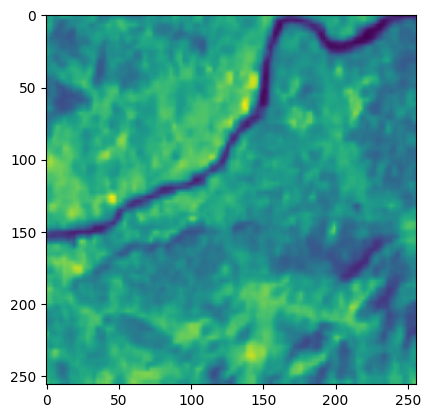

0


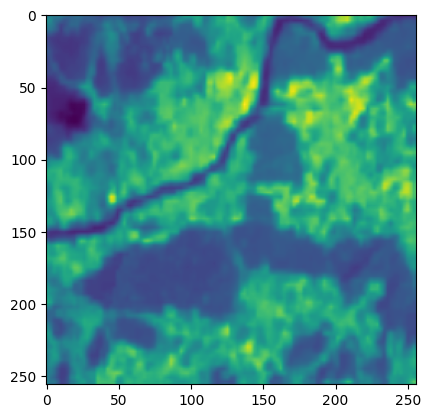

0


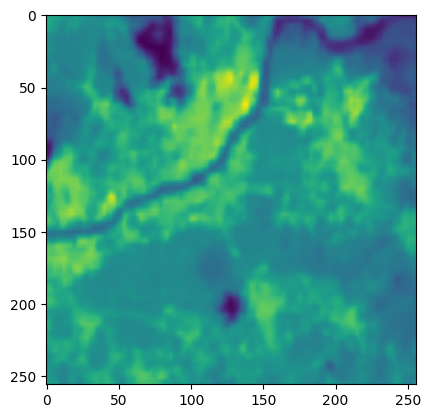

0


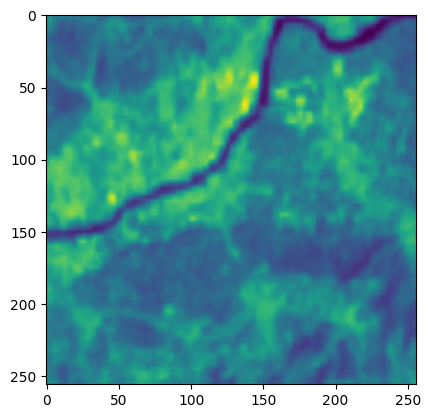

0


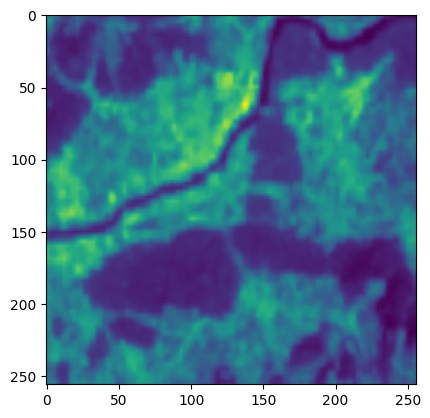

0


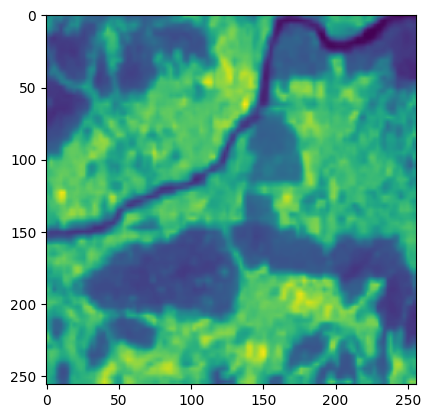

0


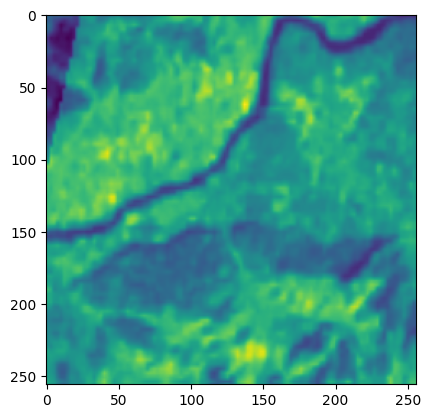

In [138]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(i)
  plt.show()

# Pixel wise dataset creation

<Axes: >

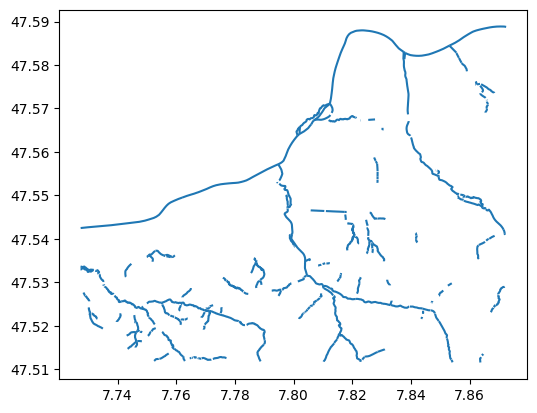

In [117]:
river_cells['cell_73'].plot()

cell_31


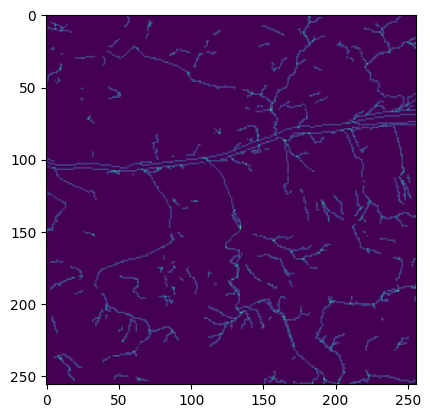

cell_71


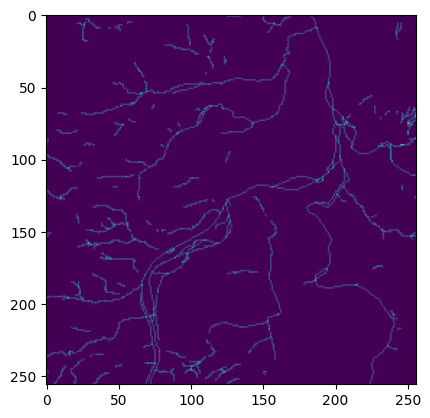

cell_1


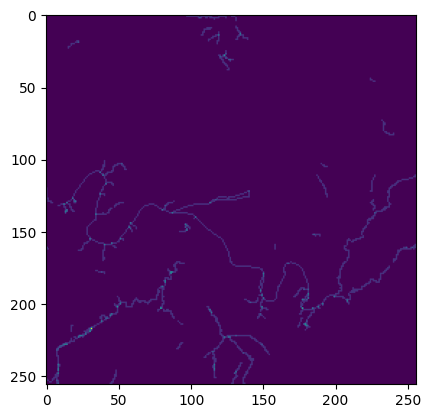

cell_45


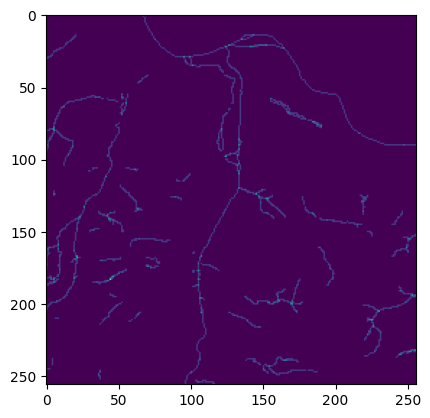

cell_35


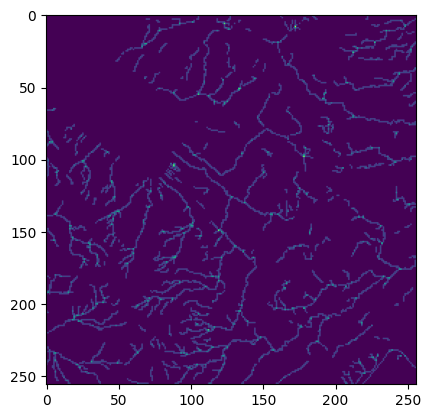

cell_25


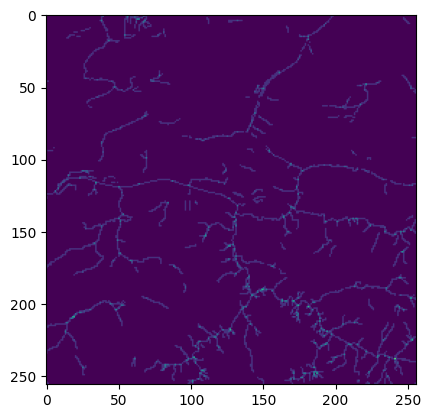

cell_21


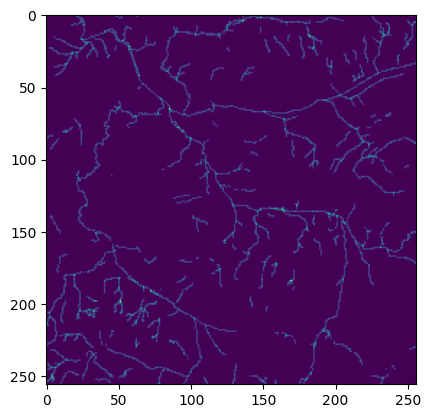

cell_51


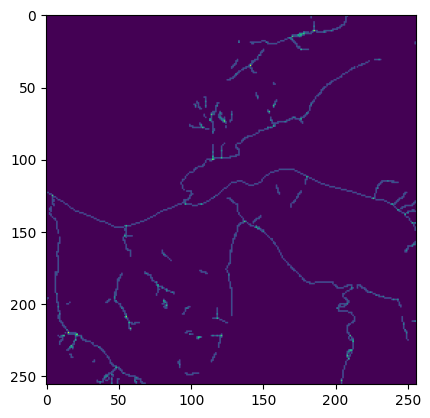

cell_49


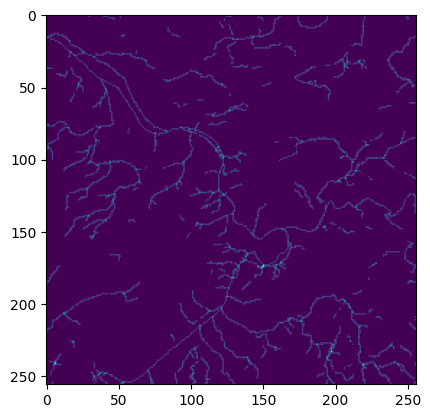

cell_12


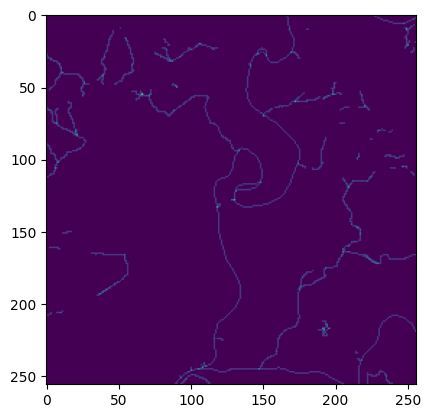

cell_58


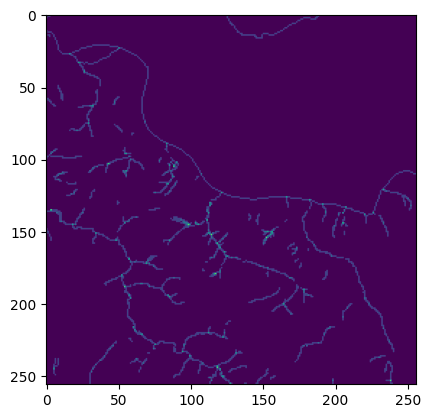

cell_46


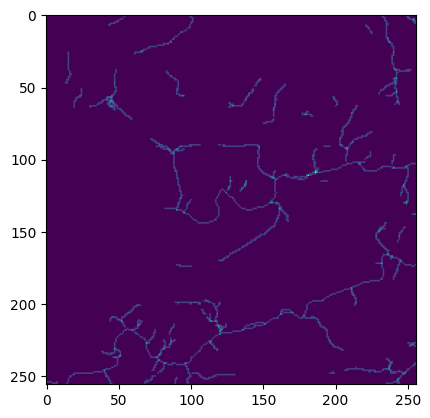

cell_53


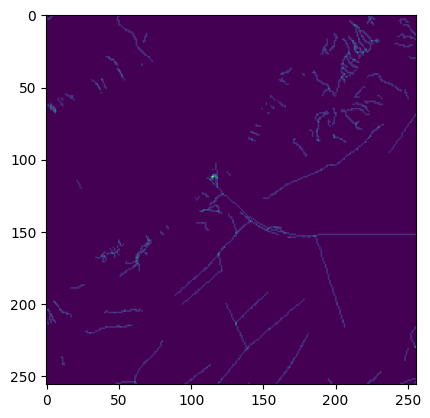

cell_55


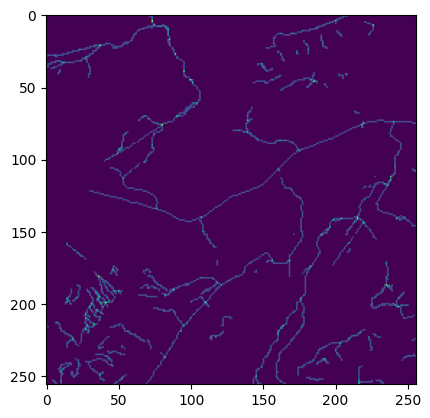

cell_5


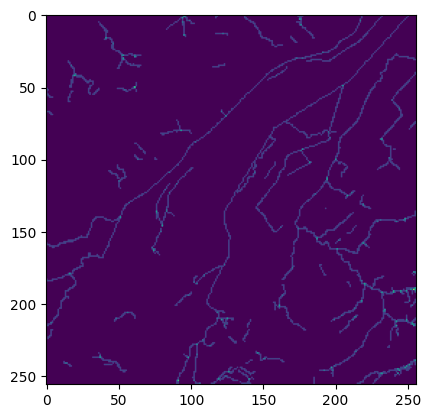

cell_62


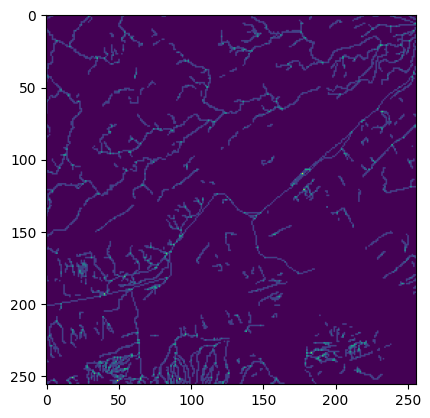

cell_67


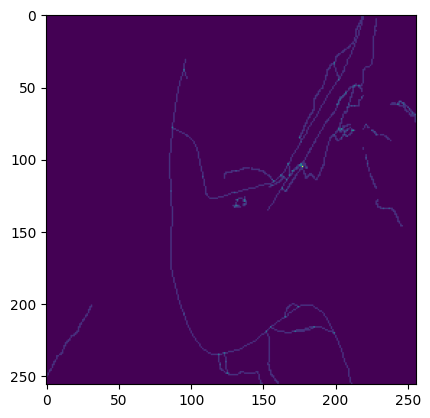

cell_14


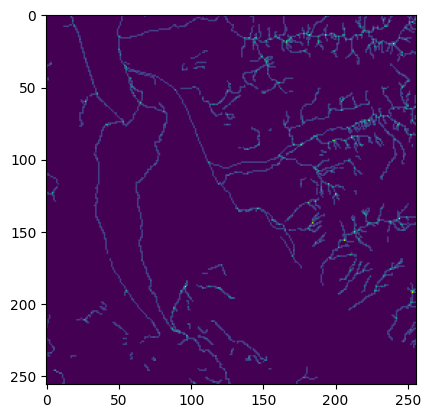

cell_24


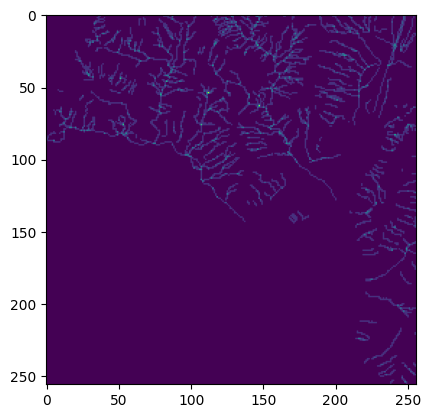

cell_26


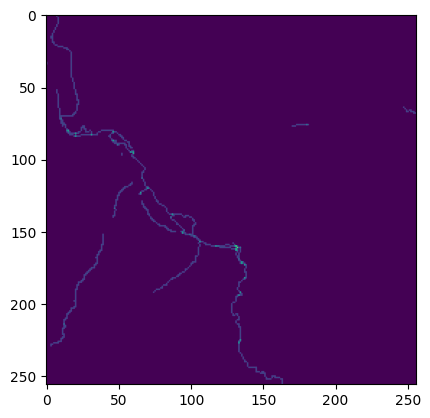

cell_81


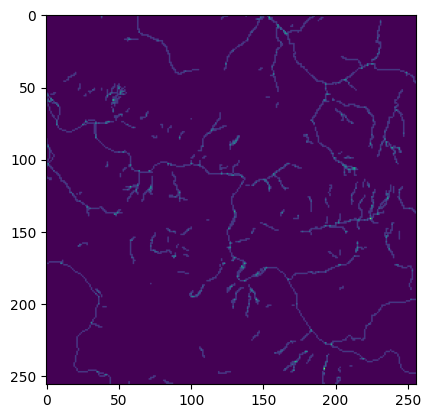

cell_54


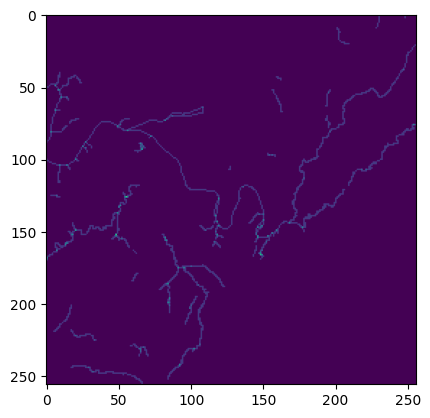

cell_9


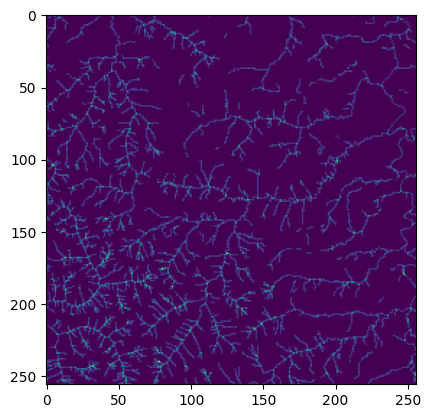

cell_73


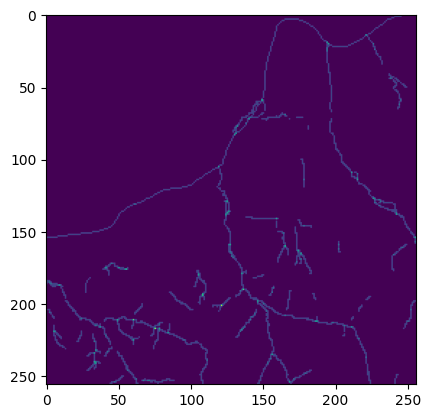

cell_69


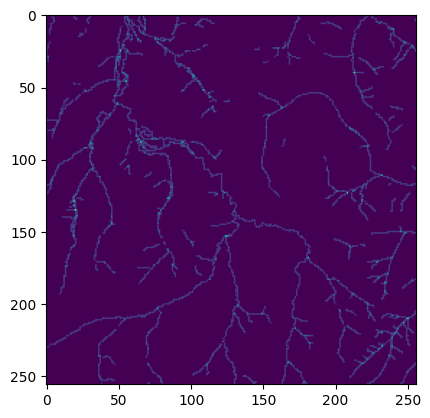

cell_47


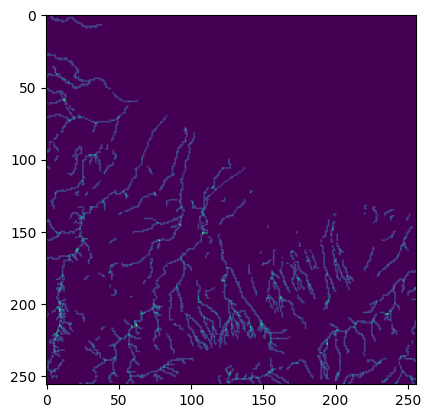

cell_15


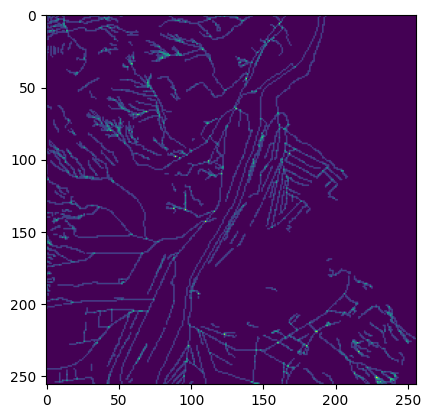

cell_11


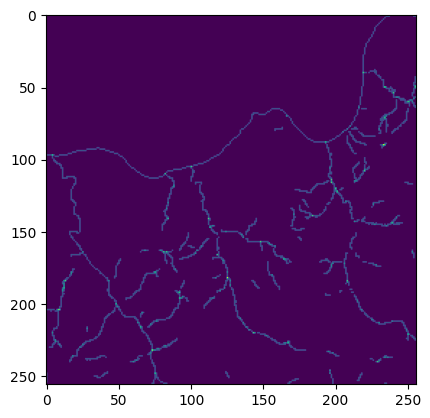

cell_20


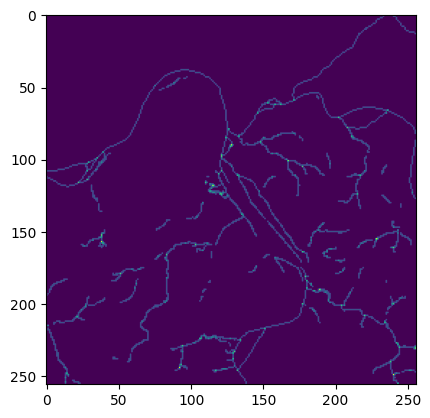

cell_70


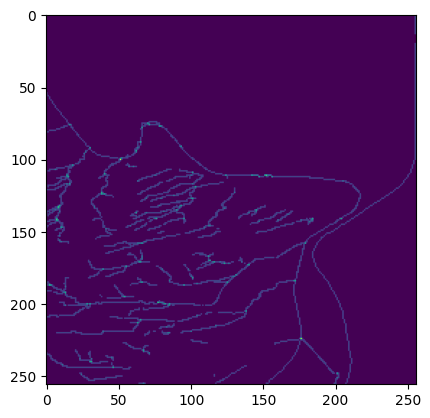

cell_22


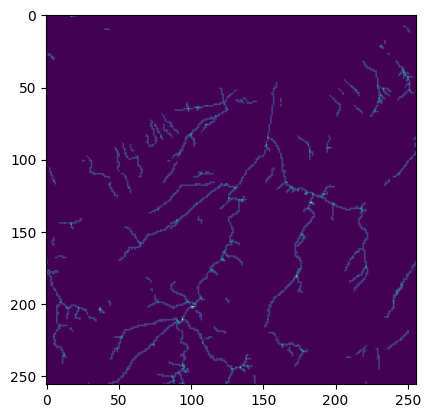

cell_65


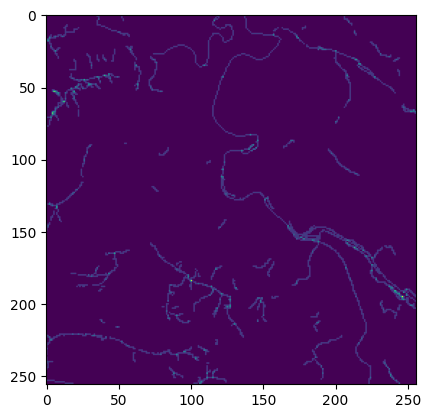

cell_4


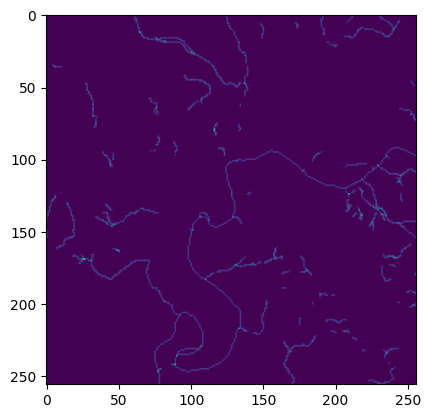

cell_13


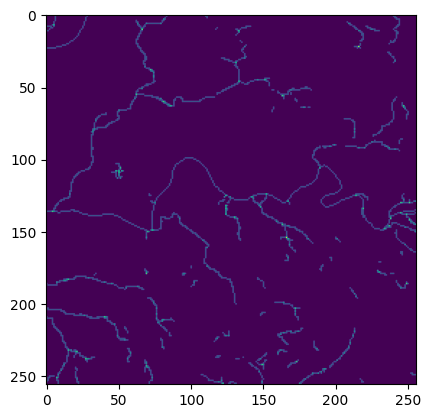

cell_41


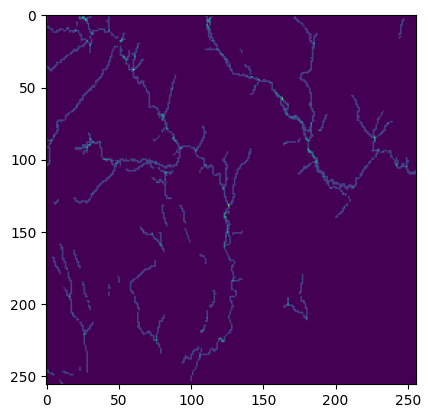

cell_63


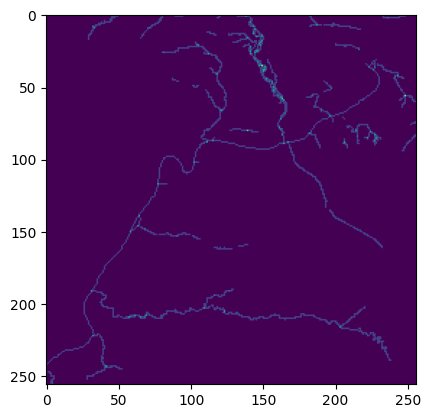

cell_79


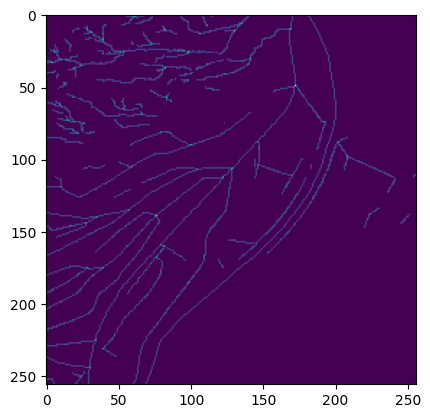

cell_19


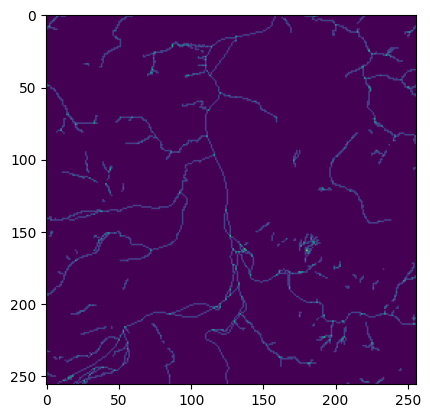

cell_75


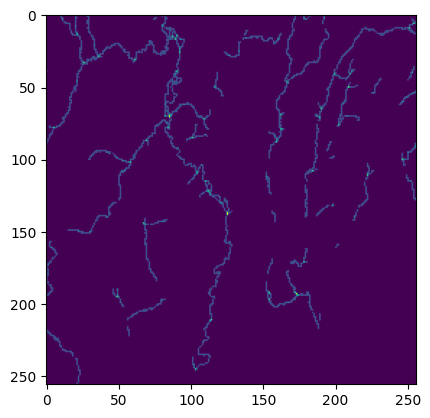

cell_48


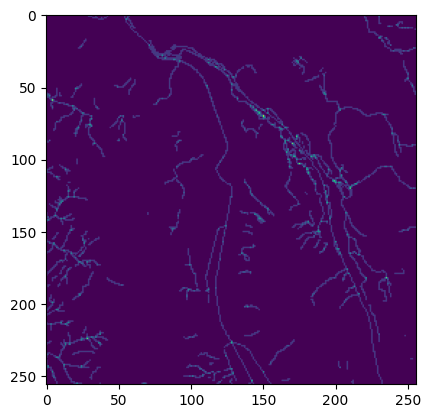

cell_27


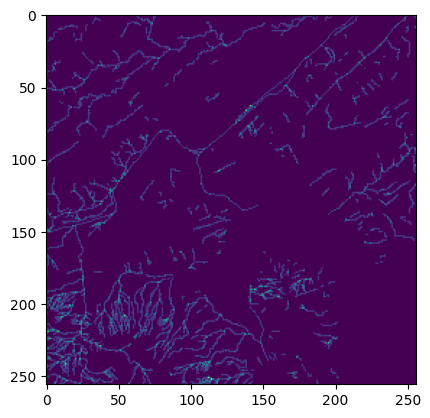

cell_56


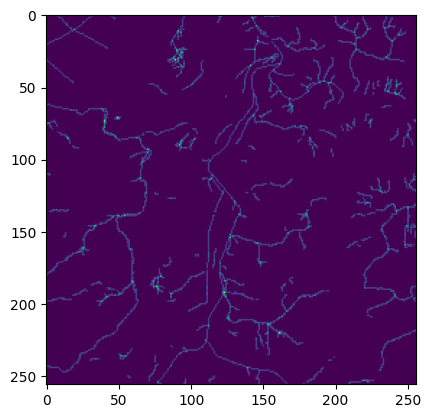

cell_36


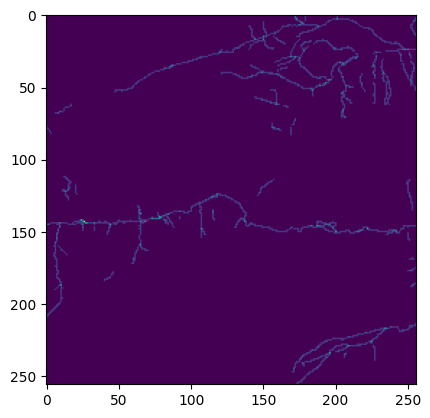

cell_7


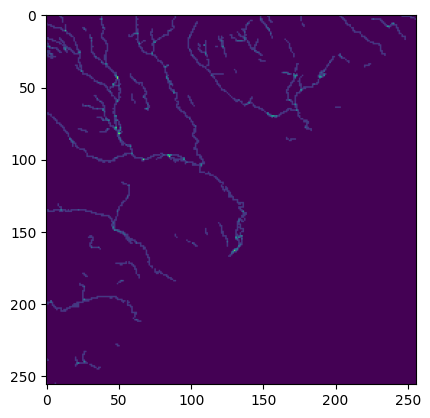

cell_52


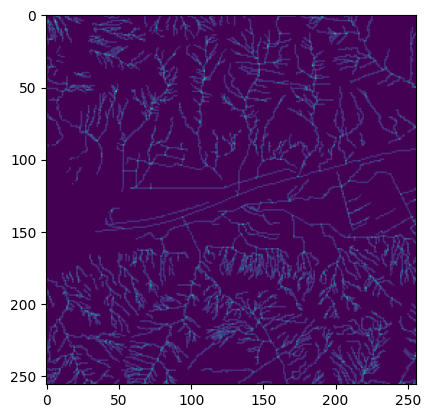

cell_61


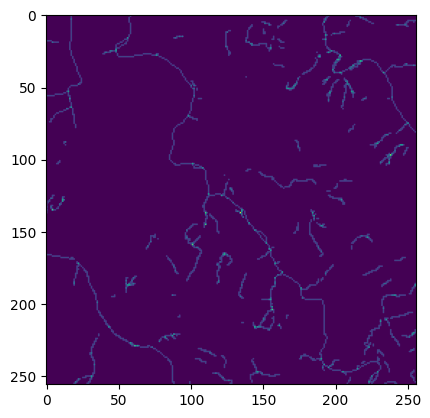

cell_72


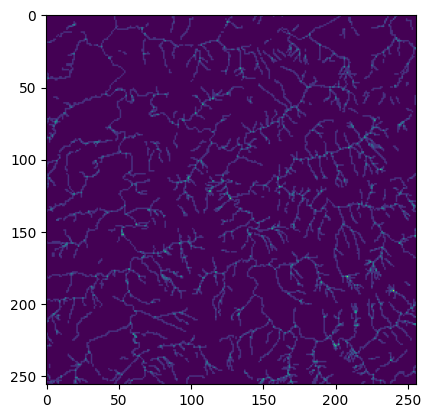

cell_38


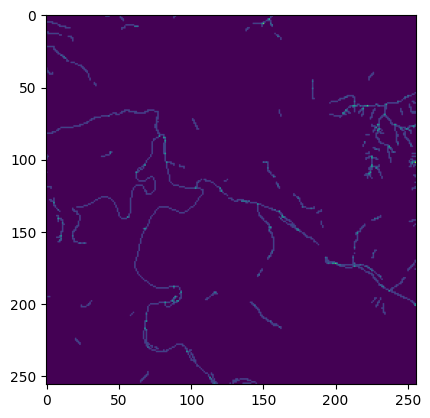

In [103]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_expanded = {}
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    river_masks[cc]=rast
    if cc in total_cells:
        print(cc)
        plt.imshow(rast)
        plt.show()
    river_mask_expanded = np.expand_dims(rast, axis=-1)  # Expande para tener forma (height, width, 1)
    river_mask_expanded = np.repeat(river_mask_expanded, lst.shape[-1], axis=-1)  # Expande a (height, width, 3)
    river_masks_expanded[cc] = river_mask_expanded
    

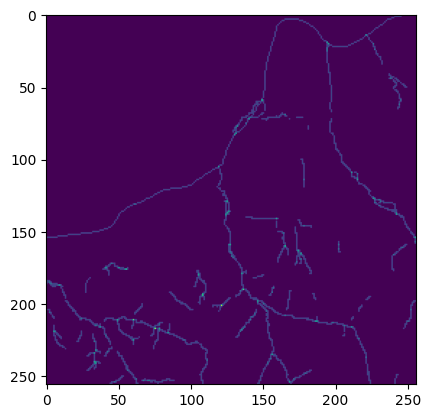

In [139]:
plt.imshow(river_masks['cell_73'])

### LST dataset

In [141]:
c=0
last = 0
for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
    try:
        river_mask = river_masks[cell]
        river_indices = np.nonzero(river_mask.reshape(-1))[0]
        pixel_ds_lst = pd.DataFrame(columns=[river_indices])
    
        for count in range(im_per_river):
            ind = count + last
            image = lst[ind]
            img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
            flat_image = img_gray.flatten()
            river_image = flat_image[river_indices]
            pixel_ds_lst.loc[t[0][c][count-1]] = river_image
        
        last += im_per_river
        print((pixel_ds_lst.shape))
        csv_path = f'{source_path}lst/{cell}/{cell}.csv'
        if os.path.exists(csv_path):
            os.remove(csv_path)
        pixel_ds_lst.to_csv(csv_path)# index=False)
        print('Guardat',csv_path)
        c+=1
    except KeyError:
        pass


(29, 1568)
Guardat ../data/raw/lst/cell_67/cell_67.csv
(9, 3235)
Guardat ../data/raw/lst/cell_70/cell_70.csv
(11, 4428)
Guardat ../data/raw/lst/cell_31/cell_31.csv
(13, 3348)
Guardat ../data/raw/lst/cell_19/cell_19.csv
(7, 3592)
Guardat ../data/raw/lst/cell_71/cell_71.csv
(20, 4725)
Guardat ../data/raw/lst/cell_49/cell_49.csv
(17, 2430)
Guardat ../data/raw/lst/cell_13/cell_13.csv
(37, 2719)
Guardat ../data/raw/lst/cell_41/cell_41.csv
(14, 4728)
Guardat ../data/raw/lst/cell_21/cell_21.csv
(6, 2391)
Guardat ../data/raw/lst/cell_11/cell_11.csv
(16, 2606)
Guardat ../data/raw/lst/cell_58/cell_58.csv
(41, 4131)
Guardat ../data/raw/lst/cell_56/cell_56.csv
(19, 6395)
Guardat ../data/raw/lst/cell_62/cell_62.csv
(14, 9302)
Guardat ../data/raw/lst/cell_72/cell_72.csv
(25, 2982)
Guardat ../data/raw/lst/cell_65/cell_65.csv
(16, 9822)
Guardat ../data/raw/lst/cell_9/cell_9.csv
(9, 4501)
Guardat ../data/raw/lst/cell_69/cell_69.csv
(32, 2280)
Guardat ../data/raw/lst/cell_46/cell_46.csv
(18, 1894)
Guard

### NDVI dataset

In [142]:
c=0
last = 0
for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
    try:
        river_mask = river_masks[cell]
        river_indices = np.nonzero(river_mask.reshape(-1))[0]
        pixel_ds_ndvi = pd.DataFrame(columns=[river_indices])
    
        for count in range(im_per_river):
            ind = count + last
            image = masked_ndvi[ind]
            flat_image = image.flatten()
            river_image = flat_image[river_indices]
            pixel_ds_ndvi.loc[t[0][c][count-1]] = river_image
        
        last += im_per_river
        print(pixel_ds_ndvi.shape)
        csv_path = f'{source_path}ndvi/{cell}/{cell}.csv'
        if os.path.exists(csv_path):
            os.remove(csv_path)
        pixel_ds_ndvi.to_csv(csv_path)#index=False)
        print('Guardat',csv_path)
        c+=1
    except KeyError:
        pass


NameError: name 'masked_ndvi' is not defined

### Water temperature dataset

In [30]:
c=0
last = 0
for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
    try:
        river_mask = river_masks[cell]
        river_indices = np.nonzero(river_mask.reshape(-1))[0]
        pixel_ds_wt = pd.DataFrame(columns=[river_indices])
    
        for count in range(im_per_river):
            ind = count + last
            image = data_targets[ind]
            flat_image = image.flatten()
            river_image = flat_image[river_indices]
            pixel_ds_wt.loc[total_times['lst'][c][count-1]] = river_image
        
        last += im_per_river
        print(pixel_ds_wt.shape)
        csv_path = f'{source_path}wt/{cell}/{cell}.csv'
        if os.path.exists(csv_path):
            os.remove(csv_path)
        pixel_ds_wt.to_csv(csv_path)#, index=False)
        print('Guardat',csv_path)
        c+=1
    except KeyError:
        pass


(8, 10266)
Guardat ../data/preprocessed/wt/cell_163/cell_163.csv
(5, 3691)
Guardat ../data/preprocessed/wt/cell_146/cell_146.csv
(3, 4548)
Guardat ../data/preprocessed/wt/cell_72/cell_72.csv
(3, 3859)
Guardat ../data/preprocessed/wt/cell_180/cell_180.csv
(7, 4227)
Guardat ../data/preprocessed/wt/cell_212/cell_212.csv
(15, 11947)
Guardat ../data/preprocessed/wt/cell_23/cell_23.csv
(20, 12913)
Guardat ../data/preprocessed/wt/cell_176/cell_176.csv
(12, 3340)
Guardat ../data/preprocessed/wt/cell_296/cell_296.csv
(7, 8374)
Guardat ../data/preprocessed/wt/cell_197/cell_197.csv
(9, 7804)
Guardat ../data/preprocessed/wt/cell_93/cell_93.csv
(17, 4024)
Guardat ../data/preprocessed/wt/cell_279/cell_279.csv
(17, 10999)
Guardat ../data/preprocessed/wt/cell_354/cell_354.csv
(24, 4658)
Guardat ../data/preprocessed/wt/cell_27/cell_27.csv


### Water temperature stations dataset

In [ ]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

In [ ]:
c = 0
for i in range(len(wt_stations)):
  if times[3][i] in slots:
    image = wt_stations[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [103]:
pixel_ds_lst

0     1     2          18         19         21         22     \
2019-08  20.521967   0.0   0.0  20.521967  20.521967  20.521967  20.521967   
2013-07  20.237665   0.0   0.0  20.237665  20.237665  20.237665  20.237665   
2013-08   2.100885   0.0   0.0   2.100885   2.100885   2.100885   2.100885   
2013-12   3.944910   0.0   0.0   3.944910   3.944910   3.944910   3.944910   
2014-01   8.486841   0.0   0.0   8.486841   8.486841   8.486841   8.486841   
2014-03  14.074945   0.0   0.0  14.074945  14.074945  14.074945  14.074945   
2014-05  19.286921   0.0   0.0  19.286921  19.286921  19.286921  19.286921   
2014-06   7.832971   0.0   0.0   7.832971   7.832971   7.832971   7.832971   
2014-11  14.357203   0.0   0.0  14.357203  14.357203  14.357203  14.357203   
2015-05  20.728327   0.0   0.0  20.728327  20.728327  20.728327  20.728327   
2015-08   4.520624   0.0   0.0   4.520624   4.520624   4.520624   4.520624   
2016-02   5.997400   0.0   0.0   5.997400   5.997400   5.997400   5.997400   
2016-03  20.406397   0.0   0.0  20.406397  20.406397  20.406397  20.406397   
2016-07  18.477381   0.0   0.0  18.477381  18.477381  18.477381  18.477381   
2016-09  11.532801   0.0   0.0  11.532801  11.532801  11.532801  11.532801   
2017-04  15.367579   0.0   0.0  15.367579  15.367579  15.367579  15.367579   
2017-05  20.731195   0.0   0.0  20.731195  20.731195  20.731195  20.731195   
2017-06  14.895472   0.0   0.0  14.895472  14.895472  14.895472  14.895472   
2017-09  19.259607   0.0   0.0  19.259607  19.259607  19.259607  19.259607   
2018-06  21.940516   0.0   0.0  21.940516  21.940516  21.940516  21.940516   
2018-08  18.461878   0.0   0.0  18.461878  18.461878  18.461878  18.461878   
2018-09   3.618310   0.0   0.0   3.618310   3.618310   3.618310   3.618310   
2018-12   8.083490   0.0   0.0   8.083490   8.083490   8.083490   8.083490   
2019-03  20.662348   0.0   0.0  20.662348  20.662348  20.662348  20.662348   

             23    30    33     ... 65415 65416 65424 65425 65441 65442 65443  \
2019-08  20.521967   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-07  20.237665   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-08   2.100885   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-12   3.944910   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-01   8.486841   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-03  14.074945   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-05  19.286921   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-06   7.832971   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-11  14.357203   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2015-05  20.728327   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2015-08   4.520624   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-02   5.997400   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-03  20.406397   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-07  18.477381   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-09  11.532801   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-04  15.367579   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-05  20.731195   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-06  14.895472   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-09  19.259607   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-06  21.940516   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-08  18.461878   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-09   3.618310   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-12   8.083490   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-03  20.662348   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

        65453      65482      65483 

In [ ]:
pixel_ds_wt.to_csv('../data/preprocessed/wt_interpolated/leboiron_wt_interpolated.csv')